# **Toxic Comments Classification**

## Part 2 - Predictive Modelling using Bag of Words (BoW)

In [34]:
# general data wrangling etc
import pandas as pd
import time

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# general text pre & postprocessing
import nltk
from nltk.tokenize import RegexpTokenizer
import re

# modelling
from sklearn import feature_extraction, metrics as smetrics, model_selection, naive_bayes, pipeline
from sklearn.pipeline import make_pipeline

In [26]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('wordnet2022')

# fix a wordnet error
!cp -rf /usr/share/nltk_data/corpora/wordnet2022 /usr/share/nltk_data/corpora/wordnet

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [27]:
# load the data
train = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/train.csv.zip')
test = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/test.csv.zip')

test_labels = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip')
test_labels.drop('id', inplace=True, axis=1)

test = pd.concat([test, test_labels], axis=1)
# remove any unlabelled data
test = test.loc[test.toxic != -1, ]

# convert to a binary classification problem
for df in [train, test]:
    int_cols = df.columns[2:]
    df['toxic_sum'] = df[int_cols].sum(axis=1)
    df['is_toxic'] = df.apply(lambda x: 1 if x['toxic_sum'] > 0 else 0, axis=1)

    df.drop('toxic_sum', axis=1, inplace=True)
    
# preprocess the text data
def preprocess_text(text, remove_num=False, remove_sw=False, sw_lst=None, lemm=True, stem=False,
                    remove_single=True):

    # remove numbers
    if remove_num:
        text = re.sub(r'[\s\d+\s]', ' ', text)
        
    # convert strings to lowercase
    text = str(text).lower()
    
    # tokenise the strings
    tokeniser = RegexpTokenizer(r'\w+')
    tokenised_text = tokeniser.tokenize(text)
    
    # remove stopwords
    if remove_sw:
        tokenised_text = [token for token in tokenised_text if token not in sw_lst]
        
    # lemmatise (convert the word into root word)
    if lemm:
        lemmatiser = nltk.stem.wordnet.WordNetLemmatizer()
        tokenised_text = [lemmatiser.lemmatize(token) for token in tokenised_text]

    # stem (remove -ing, -ly, ...)
    if stem:
        stemmer = nltk.stem.porter.PorterStemmer()
        tokenised_text = [stemmer.stem(token) for token in tokenised_text]    

    # remove single-letter words
    if remove_single:
        tokenised_text = [token for token in tokenised_text if len(token) > 1]
    
    # join back together
    text = " ".join(tokenised_text)
    
    return text

# use the nltk stopwords list
stopword_lst = nltk.corpus.stopwords.words("english")

In [29]:
# select just the text and target columns
cols = ['is_toxic', 'comment_text']

train_data = train.loc[:, cols]
test_data = test.loc[:, cols]

start_time = time.time()

# process the data
train_data['processed_comment_text'] = train_data['comment_text'].apply(lambda x: preprocess_text(
    x, remove_num=True, remove_sw=True, sw_lst=stopword_lst, lemm=True, stem=False,
    remove_single=False))
test_data['processed_comment_text'] = test_data['comment_text'].apply(lambda x: preprocess_text(
    x, remove_num=True, remove_sw=True, sw_lst=stopword_lst, lemm=True, stem=False,
    remove_single=False))

end_time = time.time()
print('Elapsed time: {:.2f} minutes'.format((end_time-start_time)/60))

# check the target class balance
train_data.is_toxic.value_counts(normalize=True)

Elapsed time: 1.38 minutes


0    0.898321
1    0.101679
Name: is_toxic, dtype: float64

Note how the dataset is very unbalanced in the target class. This is something we'll need to adjust for in our predictive modelling.

In [35]:
# rebalance the dataset (somewhat)
clean_texts = train_data[train_data.is_toxic == 0]
train_texts = train_data[train_data.is_toxic == 1]

# randomly sample from the majority class until it makes up only 80% of the dataset
to_conserve = clean_texts.sample(frac=0.42)
# # randomly sample from the majority class until it makes up about 50% of the dataset
# to_conserve = clean_texts.sample(frac=0.1, random_state=42)
train_data_rs = to_conserve.append(train_texts, ignore_index=True)
# re-check the balance
train_data_rs.is_toxic.value_counts(normalize=True)

0    0.787714
1    0.212286
Name: is_toxic, dtype: float64

In [36]:
# define the pipeline
pipeline = make_pipeline(
    # create a vectoriser
    # extract unigrams and bigrams
    # tfidf is a more advanced count vectoriser taking into account how frequently words appear across
    # documents
    feature_extraction.text.TfidfVectorizer(ngram_range=(1,2), sublinear_tf=True),
    # create a grid search object
    model_selection.GridSearchCV(
        # name the algorithm
        naive_bayes.MultinomialNB(),
        # define the hyperparameter grid
        param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10, 100]},
        cv=5,
        scoring='average_precision'
    )
)

# fit the pipeline on the training data
start_time = time.time()

pipeline.fit(train_data.processed_comment_text, train_data.is_toxic.values)

end_time = time.time()
print('Elapsed time: {:.2f} minutes'.format((end_time-start_time)/60))

# make predictions on the test data
pred_probs = pipeline.predict_proba(test_data.processed_comment_text)[:, 1]
preds = pipeline.predict(test_data.processed_comment_text)
# preds = (pred_probs >= threshold).astype(int)

Elapsed time: 0.80 minutes


AUPRC: 0.65
F1 score: 0.5
AUC: 0.91
Accuracy: 0.93
Detail:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96     57735
           1       0.84      0.35      0.50      6243

    accuracy                           0.93     63978
   macro avg       0.89      0.67      0.73     63978
weighted avg       0.92      0.93      0.92     63978



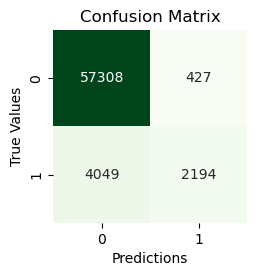

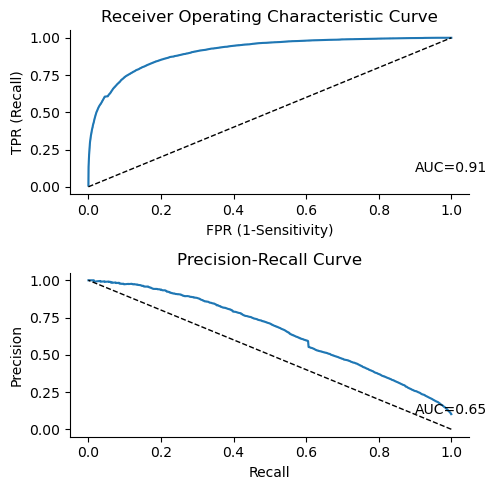

In [37]:
# evaluate model performance
auc = smetrics.roc_auc_score(y_test, pred_probs)
f1 = smetrics.f1_score(y_test, preds)
auprc = smetrics.average_precision_score(y_test, pred_probs)
accuracy = smetrics.accuracy_score(y_test, preds)

print("AUPRC:", round(auprc, 2))
print("F1 score:", round(f1, 2))
print("AUC:", round(auc, 2))
print("Accuracy:", round(accuracy, 2))
print("Detail:")
print(smetrics.classification_report(y_test, preds))

cm = smetrics.confusion_matrix(y_test, preds)
fig, ax = plt.subplots(figsize=(2.5, 2.5))
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Greens, cbar=False)
plt.xlabel("Predictions")
plt.ylabel("True Values")
plt.title("Confusion Matrix")

fig, ax = plt.subplots(figsize=(5, 5), nrows=2, ncols=1)
# plot precision-recall curve
precision, recall, thresholds = smetrics.precision_recall_curve(y_test, pred_probs)
sns.lineplot(x=recall, y=precision, ax=ax[1])
ax[1].text(x=0.9, y=0.1, s='AUC={0:0.2f}'.format(auprc))
ax[1].plot([1,0], [0,1], color='black', linestyle='--', lw=1)
ax[1].set(xlabel="Recall",
          ylabel="Precision",
          title="Precision-Recall Curve")

# plot roc curve
fpr, tpr, thresholds = smetrics.roc_curve(y_test, pred_probs)
sns.lineplot(x=fpr, y=tpr, ax=ax[0])
ax[0].text(x=0.9, y=0.1, s='AUC={0:0.2f}'.format(auc))
ax[0].plot([0,1], [0,1], color='black', linestyle='--', lw=1)
ax[0].set(xlabel="FPR (1-Sensitivity)",
          ylabel="TPR (Recall)",
          title="Receiver Operating Characteristic Curve")

fig.tight_layout()
sns.despine()